In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

# Download COCO dataset

Run "get_coco_dataset.sh" to download the training data if you haven't already

In [2]:
#Uncomment to run bash script
#!./data/get_coco_dataset.sh

In [3]:
coco_path = './data/coco.names'
train_target_txt = "./data/coco/trainvalno5k.txt"
valid_target_txt = "./data/coco/5k.txt"

In [4]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [5]:
classes = load_coco(coco_path)

# Preprocess Image

In [6]:
def letterbox_transforms(inner_dim, outer_dim):
    outer_w, outer_h = outer_dim
    inner_w, inner_h = inner_dim
    ratio = min(outer_w / inner_w, outer_h / inner_h)
    box_w = int(inner_w * ratio)
    box_h = int(inner_h * ratio)
    box_x_offset = (outer_w // 2) - (box_w // 2)
    box_y_offset = (outer_h // 2) - (box_h // 2)
    return box_w, box_h, box_x_offset, box_y_offset, ratio

def letterbox_image(img, dim):
    #Create the background
    image = np.full(dim +(3,), 128)
        
    img_dim = (img.shape[1], img.shape[0])
    box_w, box_h, box_x, box_y, ratio = letterbox_transforms(img_dim, dim)
    box_image = cv2.resize(img, (box_w,box_h), interpolation = cv2.INTER_CUBIC)
        
    #Put the box image on top of the blank image
    image[box_y:box_y+box_h, box_x:box_x+box_w] = box_image
        
    return image, (box_w, box_h, box_x, box_y, ratio)

# Mode - letterbox, resize
def load_image(img_path, mode=None, dim=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_org_dim = (img.shape[1], img.shape[0])
    trans = None
    if mode is not None and dim is not None:
        if mode == 'letterbox':
            img, trans = letterbox_image(img, dim)
        elif mode == 'resize':
            img = cv2.resize(img, dim)
    
    img = torch.from_numpy(img).float().permute(2,0,1) / 255
    return img, img_org_dim, trans

# Draw

In [7]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=0.5))
    draw_outline(patch, 2)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bbox_plt(box):
    bx, by = box[0], box[1]
    bw = box[2] - box[0]
    bh = box[3] - box[1]
    return [bx, by, bw, bh]

def bbox_center2corner(box):
    cx, cy, w, h = box[0], box[1], box[2], box[3]
    x = cx - w/2
    y = cy - h/2
    return [x,y,w,h]

def show_output(img, dets):
    ax = show_img(img, figsize=(16,8))
    for d in dets:
        rect = bbox_center2corner(d)
        draw_rect(ax, rect[:4])
        c = classes[d[-1].int().item()]
        draw_text(ax, rect[:2], c)

In [8]:
import matplotlib.ticker as plticker
def show_grid(ax, grid_interval):
    loc = plticker.MultipleLocator(base=grid_interval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


# Dataset

In [9]:
def bbox_letterbox_transform_reverse(box, x_max, y_max, x_offset, y_offset, ratio):
    box[:,[0,2]] = torch.clamp((box[:,[0,2]] - x_offset) / ratio, 0, x_max)
    box[:,[1,3]] = torch.clamp((box[:,[1,3]] - y_offset) / ratio, 0, y_max)
    return box

def bbox_corner_letterbox_transform(box, x_offset, y_offset, ratio):
    box[:,[0,2]] = box[:,[0,2]] * ratio + x_offset
    box[:,[1,3]] = box[:,[1,3]] * ratio + y_offset
    return box

def bbox_center_letterbox_transform(box, x_offset, y_offset, ratio):
    box[:,:] = box[:,:] * ratio 
    box[:,0] = box[:,0] + x_offset
    box[:,1] = box[:,1] + y_offset
    return box

In [10]:
def bbox_center2corner(box):
    cx, cy, w, h = box[...,0], box[...,1], box[...,2], box[...,3]
    box[...,0] = cx - w/2
    box[...,1] = cy - h/2
    box[...,2] = box[...,0] + w
    box[...,3] = box[...,1] + h
    return box

def bbox_corner2center(box):
    x1, y1, x2, y2 = box[...,0], box[...,1], box[...,2], box[...,3]
    box[...,0] = (x1 + x2) /2
    box[...,1] = (y1 + y2) /2
    box[...,2] = (box[...,2] - box[...,0]) * 2
    box[...,3] = (box[...,3] - box[...,1]) * 2
    return box

def bbox_corner2cornerHW(box):
    x1, y1, x2, y2 = box[...,0], box[...,1], box[...,2], box[...,3]
    box[...,2] = x2 - x1
    box[...,3] = y2 - y1
    return box

In [11]:
def letterbox_label(label, box_w, box_h, box_x_offset, box_y_offset, ratio, dim):
    label_x_offset = box_x_offset / dim[0]
    label_y_offset = box_y_offset / dim[1]
    box_w_ratio = box_w / dim[0]
    box_h_ratio = box_h / dim[1]
    label[:, [1,3]] = label[:, [1,3]] * box_w_ratio 
    label[:, [2,4]] = label[:, [2,4]] * box_h_ratio
    label[:, 1] = label[:, 1] + label_x_offset
    label[:, 2] = label[:, 2] + label_y_offset
    return label

def fill_label_np_tensor(label, row, col):
    label_tmp = np.full((row, col), 0.0)
    if label is not None:
        label_tmp[:label.shape[0]] = label
    return label_tmp   

In [12]:
class COCODataset(Dataset):
    def __init__(self, targ_txt, dim=None):
        with open(targ_txt, 'r') as f:
            self.img_list = [lines.strip() for lines in f.readlines()]
        self.label_list = [img_path.replace('jpg', 'txt').replace('images', 'labels') for img_path in self.img_list]
        self.dim = dim
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        label = None
        img_path = self.img_list[idx]
        if osp.exists(img_path):
            img, img_org_dim, trans = load_image(img_path, mode='letterbox', dim=self.dim)
        
        label_path = self.label_list[idx]
        if osp.exists(label_path):
            label = np.loadtxt(label_path).reshape(-1,5)
        
        if label is not None:
            label = letterbox_label(label, *trans, self.dim)
        label = fill_label_np_tensor(label, 50, 5)
        label = torch.from_numpy(label)
    
        return img, label

In [13]:
def test_show_output(img, dets, draw_grid=True):
    ax = show_img(img, figsize=(16,8))
    if draw_grid:
        ax = show_grid(ax, 32)
    for d in dets:
        if d.sum() == 0:
            break
            
        rect = bbox_corner2cornerHW(bbox_center2corner(d[1:5]))
        rect = rect * img.shape[0]
        draw_rect(ax, rect)
        c = classes[d[0].int().item()]
        draw_text(ax, rect[:2], c)

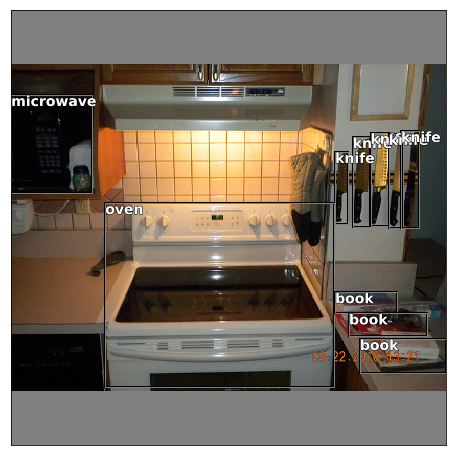

In [14]:
trainDS = COCODataset(train_target_txt, dim=(416,416))
img, label = trainDS[14]
test_show_output(img.permute(1,2,0), label, False)